Dữ liệu đầu vào SMOTE:
X shape: (2814, 23)
y shape: (2814,)
Kích thước tập huấn luyện: (2906, 1, 23), Tập kiểm tra: (623, 1, 23), Tập thử: (623, 1, 23)


C:\Users\PC\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Epoch 1/100
91/91 [==============================] - 4s 10ms/step - loss: 1.0160 - accuracy: 0.5265 - recall: 0.5962 - val_loss: 0.7792 - val_accuracy: 0.4510 - val_recall: 1.0000 - lr: 0.0010
Epoch 2/100
91/91 [==============================] - 0s 4ms/step - loss: 0.8569 - accuracy: 0.5970 - recall: 0.7259 - val_loss: 0.8219 - val_accuracy: 0.4510 - val_recall: 1.0000 - lr: 0.0010
Epoch 3/100
91/91 [==============================] - 0s 4ms/step - loss: 0.8131 - accuracy: 0.6060 - recall: 0.7819 - val_loss: 0.7990 - val_accuracy: 0.4510 - val_recall: 1.0000 - lr: 0.0010
Epoch 4/100
91/91 [==============================] - 0s 4ms/step - loss: 0.7968 - accuracy: 0.6242 - recall: 0.7725 - val_loss: 0.7622 - val_accuracy: 0.4703 - val_recall: 0.9964 - lr: 0.0010
Epoch 5/100
91/91 [==============================] - 0s 4ms/step - loss: 0.7762 - accuracy: 0.6266 - recall: 0.7779 - val_loss: 0.7170 - val_accuracy: 0.5474 - val_recall: 0.9573 - lr: 0.0010
Epoch 6/100
91/91 [====================

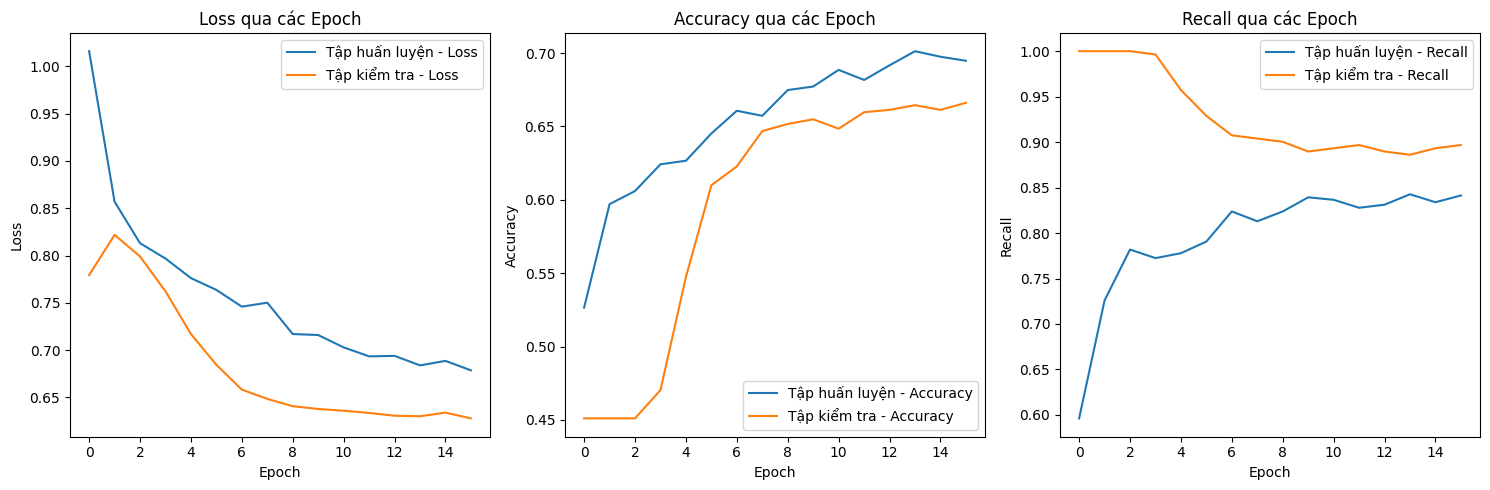

In [10]:
import os
os.environ["PYSPARK_PYTHON"] = r"C:\Users\PC\AppData\Local\Programs\Python\Python39\python.exe"
os.environ["PYSPARK_DRIVER_PYTHON"] = r"C:\Users\PC\AppData\Local\Programs\Python\Python39\python.exe"

from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StandardScaler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

# Khởi tạo SparkSession
spark = SparkSession.builder \
    .appName("BloodCancerLSTM") \
    .config("spark.executor.memory", "16g") \
    .config("spark.driver.memory", "16g") \
    .config("spark.driver.maxResultSize", "8g") \
    .config("spark.python.worker.connectionTimeout", "600s") \
    .getOrCreate()

# Đọc file CSV
data = spark.read.csv("blood_cancer_test_result1.csv", header=True, inferSchema=True)

# Xử lý ngoại lai
def remove_outliers_spark(df, columns):
    for col_name in columns:
        quantiles = df.approxQuantile(col_name, [0.25, 0.75], 0.05)
        Q1, Q3 = quantiles[0], quantiles[1]
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df.filter((col(col_name) >= lower_bound) & (col(col_name) <= upper_bound))
    return df

numeric_cols = [c for c in data.columns if c != 'Predicted_Class']
data = remove_outliers_spark(data, numeric_cols)

# Chuẩn hóa đặc trưng
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
data_assembled = assembler.transform(data)
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(data_assembled)
data_scaled = scaler_model.transform(data_assembled)

# Chuyển về Pandas để áp dụng SMOTE
data_pandas = data_scaled.select("scaled_features", "Predicted_Class").toPandas()
X = np.array([np.array(row.scaled_features) for row in data_pandas.itertuples(index=False)])
y = np.array(data_pandas['Predicted_Class'].values)

print("Dữ liệu đầu vào SMOTE:")
print("X shape:", X.shape)
print("y shape:", y.shape)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Chia dữ liệu trong Pandas
X_train, X_temp, y_train, y_temp = train_test_split(
    X_resampled, y_resampled, train_size=0.7, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

def to_lstm_format(X, y):
    X = X.reshape((X.shape[0], 1, X.shape[1]))
    return X, y

X_train, y_train = to_lstm_format(X_train, y_train)
X_val, y_val = to_lstm_format(X_val, y_val)
X_test, y_test = to_lstm_format(X_test, y_test)

print(f"Kích thước tập huấn luyện: {X_train.shape}, Tập kiểm tra: {X_val.shape}, Tập thử: {X_test.shape}")

# Xây dựng và huấn luyện mô hình LSTM
n_features = X_train.shape[2]
model = Sequential([
    LSTM(128, input_shape=(1, n_features), return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(64),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Recall(name='recall')])

# Tính trọng số lớp
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train.flatten())
class_weight_dict = dict(zip(classes, class_weights))
class_weight_dict[1] = class_weight_dict[1] * 1.5

# Callbacks
early_stopping = EarlyStopping(monitor='val_recall', patience=15, restore_best_weights=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_recall', factor=0.5, patience=5, min_lr=1e-6, mode='max')

# Huấn luyện
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight_dict,
    verbose=1
)

# Tìm ngưỡng tối ưu
y_val_prob = model.predict(X_val)
fpr, tpr, thresholds = roc_curve(y_val, y_val_prob)
f1_scores = [f1_score(y_val, (y_val_prob > t).astype(int)) for t in thresholds]
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"Ngưỡng tối ưu cho F1-score: {optimal_threshold:.3f}")

# Đánh giá
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > optimal_threshold).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

print("\nKết quả trên tập thử:")
print(f"Độ chính xác (Accuracy): {accuracy:.3f}")
print(f"Độ chính xác (Precision): {precision:.3f}")
print(f"Độ nhạy (Recall): {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"AUC-ROC: {auc:.3f}")

# Vẽ biểu đồ
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Tập huấn luyện - Loss')
plt.plot(history.history['val_loss'], label='Tập kiểm tra - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss qua các Epoch')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Tập huấn luyện - Accuracy')
plt.plot(history.history['val_accuracy'], label='Tập kiểm tra - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy qua các Epoch')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['recall'], label='Tập huấn luyện - Recall')
plt.plot(history.history['val_recall'], label='Tập kiểm tra - Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall qua các Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('training_history_blood_cancer.png')
plt.show()

# Đóng SparkSession
spark.stop()